# 6.2. Gerenciamento de parâmetros

Quando nos afastamos das arquiteturas empilhadas com camadas padrão, às vezes precisaremos entrar no meio da declaração e manipulação de parâmetros. Nesta seção, abordamos o seguinte:

Acessando parâmetros para depuração, diagnósticos e visualizações.

Compartilhando parâmetros entre diferentes componentes do modelo.

In [171]:
import torch
from torch import nn

Começamos focando em um MLP com uma camada oculta.

In [172]:
net = nn.Sequential(nn.LazyLinear(8),      # 8 parâmetros de saída.                           # net[0]
                    nn.ReLU(),             # função de ativação. Aplicando não-linearidade.   # net[1]
                    nn.LazyLinear(1))      # 1 parâmetro de saída.                            # net[2] ou net[-1] (índice para acessar última camada)

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [173]:
net              # Arquitetura da rede

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [175]:
net(X)          # Saídas da rede

tensor([[-0.2796],
        [-0.2690]], grad_fn=<AddmmBackward0>)

# 6.2.1. Acesso aos parâmetros

Vamos começar explicando como acessar parâmetros dos modelos que você já conhece.

Quando um modelo é definido por meio da classe Sequential, podemos primeiro acessar qualquer camada indexando no modelo como se fosse uma lista. 

Os parâmetros de cada camada estão convenientemente localizados em seu atributo.

Podemos inspecionar os parâmetros da segunda camada totalmente conectada da seguinte maneira.

In [12]:
net[2].state_dict()           # Acessa W e b da segunda camada

OrderedDict([('weight',
              tensor([[-0.2843, -0.1212,  0.2933, -0.0527, -0.0975,  0.1554, -0.3045, -0.3302]])),
             ('bias', tensor([-0.0044]))])

In [16]:
net[2].state_dict()['bias']   # state_dict() é um dicionário, portanto, o acesso é pela etiqueta.

tensor([-0.0044])

# 6.2.1.1. Parâmetros Alvo

Acessando parâmetros em separado.

O código a seguir extrai o bias da segunda camada de rede neural, que retorna uma instância de classe de parâmetro e acessa o valor desse parâmetro.

In [19]:
type(net[2].bias)

torch.nn.parameter.Parameter

In [20]:
net[2].bias.data    # OU: net[2].state_dict()['bias']   # state_dict() é um dicionário, portanto, o acesso é pela etiqueta.

tensor([-0.0044])

In [21]:
net[2].state_dict()['bias']   # state_dict() é um dicionário, portanto, o acesso é pela etiqueta.

tensor([-0.0044])

In [25]:
net[2].weight.data



tensor([[-0.2843, -0.1212,  0.2933, -0.0527, -0.0975,  0.1554, -0.3045, -0.3302]])

In [94]:
net[2].weight.data[0][2]   # ou net[2].weight.data[0,2]

tensor(0.2933)

Maneira alternativa:

In [27]:
a = net[2].state_dict()
a.get('bias')

tensor([-0.0044])

Parâmetros são objetos complexos que contêm valores, gradientes e informações adicionais. É por isso que precisamos solicitar o valor explicitamente.

Além do valor, cada parâmetro também nos permite acessar o gradiente. Como ainda não invocamos a retropropagação para esta rede, ela está em seu estado inicial.

In [29]:
print(net[2].weight.grad)

None


In [30]:
net[2].weight.grad == None

True

# 6.2.1.2. Todos os parâmetros de uma vez

Abaixo demonstramos o acesso aos parâmetros de todas as camadas.

In [32]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

In [31]:
# Size of parameters
for param in net.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([8, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([8])
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 8])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])


# 6.2.2. Parâmetros vinculados

Frequentemente, queremos compartilhar parâmetros entre múltiplas camadas. Vamos ver como fazer isso elegantemente. A seguir, alocamos uma camada totalmente conectada e então usamos seus parâmetros especificamente para definir aqueles de outra camada. Aqui, precisamos executar a propagação para frente (forward propagation) net(X) antes de acessar os parâmetros.

In [95]:
# We need to give the shared layer a name so that we can refer to its parameters
shared = nn.LazyLinear(8)                            # camada com parâmetros compartilhados                           
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)


# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100


# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


Ao alterar o valor de data[0,0] para 100 em net[2], o valor também foi alterado em net[4], pois ambos são o shared = nn.LazyLinear(8), criado no início.

Este exemplo mostra que os parâmetros da segunda e quarta camadas estão empatados. Eles não são apenas iguais, eles são representados pelo mesmo tensor. Assim, se mudarmos um dos parâmetros, o outro também muda.

In [96]:
net(X)

tensor([[-13.6006],
        [ -0.2960]], grad_fn=<AddmmBackward0>)

In [103]:
net[2].weight.data[0]    # primeiro shared. Segunda camada.

tensor([ 1.0000e+02, -1.8754e-01,  7.9713e-02,  1.7397e-02,  2.1654e-01,
        -2.4279e-01, -2.1156e-01, -3.1399e-01])

In [104]:
net[4].weight.data[0]    # segundo shared. Quarta camada.


tensor([ 1.0000e+02, -1.8754e-01,  7.9713e-02,  1.7397e-02,  2.1654e-01,
        -2.4279e-01, -2.1156e-01, -3.1399e-01])

In [122]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])
print(net[5])
print(net[6])

Linear(in_features=4, out_features=8, bias=True)
ReLU()
Linear(in_features=8, out_features=8, bias=True)
ReLU()
Linear(in_features=8, out_features=8, bias=True)
ReLU()
Linear(in_features=8, out_features=1, bias=True)


# 6.2.4. Exercises

# Ex. 1 - Utilize o NestMLPmodelo definido na Seção 6.1 e acesse os parâmetros das diversas camadas.

In [109]:
import torch
from torch import nn
from torch.nn import functional as F

# --------------------------------------------------------------------------------------------------------------------
# Classe com parâmetros constantes:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()                                    # invoca o método __init__() de nn.Module (classe pai): método construtor.
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))    # CONSTANT random weight parameters
        self.linear = nn.LazyLinear(20)            # A rede passa a saída desta camada “fixa” através de uma camada totalmente conectada.     
 
    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:       # while arbitrário, apenas a título de ilustração, demonstrando que manipulações podem ser realizadas.
            X /= 2
        return X.sum()
# --------------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------------
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()

        # Utiliza o net individual (sem classe) do início da seção
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(), # primeira camada
                                 nn.LazyLinear(32), nn.ReLU()) # segunda camada
        self.linear = nn.LazyLinear(16)                        # camada de saída

    def forward(self, X):
        return self.linear(self.net(X))
# --------------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------------
chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)
# --------------------------------------------------------------------------------------------------------------------


# Sequential(
#   (0): NestMLP(
#     (net): Sequential(
#       (0): Linear(in_features=20, out_features=64, bias=True)
#       (1): ReLU()
#       (2): Linear(in_features=64, out_features=32, bias=True)
#       (3): ReLU()
#     )
#     (linear): Linear(in_features=32, out_features=16, bias=True)
#   )

#   (1): Linear(in_features=16, out_features=20, bias=True)

#   (2): FixedHiddenMLP(
#     (linear): Linear(in_features=20, out_features=20, bias=True)
#   )
# )

tensor(0.1236, grad_fn=<SumBackward0>)

In [177]:
chimera

Sequential(
  (0): NestMLP(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (1): Linear(in_features=16, out_features=20, bias=True)
  (2): FixedHiddenMLP(
    (linear): Linear(in_features=20, out_features=20, bias=True)
  )
)

In [160]:
chimera.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): NestMLP(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (1): Linear(in_features=16, out_features=20, bias=True)
  (2): FixedHiddenMLP(
    (linear): Linear(in_features=20, out_features=20, bias=True)
  )
)>

In [110]:
[(name, param.shape) for name, param in chimera.named_parameters()]

[('0.net.0.weight', torch.Size([64, 4])),
 ('0.net.0.bias', torch.Size([64])),
 ('0.net.2.weight', torch.Size([32, 64])),
 ('0.net.2.bias', torch.Size([32])),
 ('0.linear.weight', torch.Size([16, 32])),
 ('0.linear.bias', torch.Size([16])),
 ('1.weight', torch.Size([20, 16])),
 ('1.bias', torch.Size([20])),
 ('2.linear.weight', torch.Size([20, 20])),
 ('2.linear.bias', torch.Size([20]))]

In [154]:
[(name) for name, param in chimera.named_parameters()]

['0.net.0.weight',
 '0.net.0.bias',
 '0.net.2.weight',
 '0.net.2.bias',
 '0.linear.weight',
 '0.linear.bias',
 '1.weight',
 '1.bias',
 '2.linear.weight',
 '2.linear.bias']

In [155]:
chimera.state_dict()  # Todos os w e b descritos acima.

# Modo alternativo:
# [(param) for name, param in chimera.named_parameters()]

OrderedDict([('0.net.0.weight',
              tensor([[ 0.3936, -0.4079, -0.0460, -0.4198],
                      [ 0.2749, -0.4761,  0.0365,  0.2032],
                      [ 0.1331, -0.4353,  0.0292,  0.3846],
                      [-0.2119, -0.2040, -0.1774,  0.0535],
                      [ 0.4061,  0.4073,  0.2585,  0.0162],
                      [ 0.0798, -0.2143, -0.3893,  0.4136],
                      [-0.0909,  0.2465,  0.2347, -0.3335],
                      [-0.3360,  0.1236, -0.2532, -0.2393],
                      [-0.0367, -0.2987,  0.4185,  0.2641],
                      [ 0.3773,  0.0627,  0.3792,  0.1661],
                      [ 0.0071,  0.2610,  0.2492, -0.3601],
                      [-0.3381,  0.3975, -0.0109,  0.4743],
                      [ 0.2720, -0.0761, -0.3397, -0.0627],
                      [ 0.1962,  0.0299,  0.4222, -0.3139],
                      [-0.3608,  0.2776,  0.4005, -0.2566],
                      [ 0.0474, -0.1361, -0.4886,  0.1733],
        

In [123]:
print(chimera[0])

NestMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (linear): Linear(in_features=32, out_features=16, bias=True)
)


In [128]:
print(chimera[1])
print(chimera[2])

Linear(in_features=16, out_features=20, bias=True)
FixedHiddenMLP(
  (linear): Linear(in_features=20, out_features=20, bias=True)
)


In [144]:
chimera[0].net[2].weight.data.shape

torch.Size([32, 64])

In [142]:
chimera[0].net[2].weight.data

tensor([[-0.1185,  0.0146,  0.0778,  ...,  0.0179, -0.0467,  0.0799],
        [ 0.0271, -0.0837, -0.0002,  ...,  0.0835, -0.0138,  0.0746],
        [ 0.0933,  0.0285, -0.0753,  ...,  0.0254, -0.0029, -0.0993],
        ...,
        [-0.0557, -0.0191, -0.0868,  ..., -0.0985, -0.0144,  0.0929],
        [-0.0386, -0.0919, -0.0567,  ...,  0.0063,  0.0935, -0.1020],
        [ 0.1199,  0.0481,  0.0993,  ...,  0.0992,  0.0558, -0.0155]])

In [143]:
chimera[0].net[2].weight.data[0]

tensor([-0.1185,  0.0146,  0.0778,  0.0110, -0.0351,  0.0240,  0.1081, -0.0571,
         0.0428, -0.0664, -0.0898,  0.0174, -0.0088,  0.1216, -0.0510,  0.1178,
        -0.0282, -0.0235,  0.0236,  0.0809,  0.0870,  0.0398,  0.1157,  0.0180,
         0.0976, -0.0958, -0.0854,  0.0403,  0.0165, -0.0967,  0.1195, -0.0208,
         0.0867, -0.0880, -0.0362,  0.0686,  0.1220, -0.1185,  0.0061,  0.0694,
        -0.0827,  0.0331, -0.0943, -0.0668, -0.0233,  0.0042, -0.0931, -0.1056,
         0.0915,  0.0634,  0.0316, -0.0395, -0.1082,  0.1114,  0.0884,  0.0319,
         0.0038, -0.0892,  0.0647,  0.0705,  0.0511,  0.0179, -0.0467,  0.0799])

In [145]:
chimera[0].net[2].bias.data

tensor([-0.0408,  0.0271,  0.1148,  0.0775, -0.1167, -0.1004,  0.0721,  0.0884,
        -0.1134, -0.0522, -0.1050, -0.0393,  0.0407, -0.1124,  0.0182, -0.0478,
         0.0158, -0.1162, -0.0533,  0.1030,  0.0959, -0.0256, -0.0147, -0.1028,
         0.0074,  0.0118,  0.0535,  0.1158, -0.0069,  0.0962,  0.0005,  0.1165])

In [147]:
chimera[0].net[2].bias.data[3]

tensor(0.0775)

<bound method Module.named_parameters of Sequential(
  (0): NestMLP(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (1): Linear(in_features=16, out_features=20, bias=True)
  (2): FixedHiddenMLP(
    (linear): Linear(in_features=20, out_features=20, bias=True)
  )
)>

# Ex. 2 - Construa um MLP contendo uma camada de parâmetros compartilhados e treine-o. Durante o processo de treinamento, observe os parâmetros do modelo e gradientes de cada camada.

torch.Size([256])
torch.Size([256])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
    

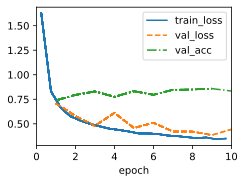

In [170]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------

# We need to give the shared layer a name so that we can refer to its parameters
shared = nn.LazyLinear(256)                 # camada com parâmetros compartilhados

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()

        # self.net = nn.Sequential(nn.Flatten(),                 # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
        #                          nn.LazyLinear(num_hiddens),   # camada escondida. Ainda é Linear.
        #                          nn.ReLU(),                    # função de ativação. Converte a função em não Linear.
        #                          nn.LazyLinear(num_outputs))   # camada de saída

        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_hiddens), nn.ReLU(),
                                 shared, nn.ReLU(),
                                 shared, nn.ReLU(),
                                 nn.LazyLinear(num_outputs))


# --------------------------------------------------------------------------------------------------------------------
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=256)
trainer.fit(model, data)
# --------------------------------------------------------------------------------------------------------------------

[(name, param.shape) for name, param in model.named_parameters()]

print(model.net[3].weight.data[0].shape)
print(model.net[5].weight.data[0].shape)
print(model.net[3].weight.data[0] == model.net[5].weight.data[0])

print(model.net[3].weight.data.shape)
print(model.net[5].weight.data.shape)
print(model.net[3].weight.data == model.net[5].weight.data)

Outra resposta:

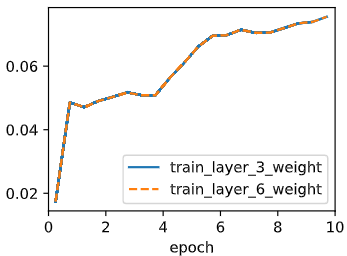

https://pandalab.me/archives/parameter_management

Utilizando plot_flag

# Ex. 3 - Por que compartilhar parâmetros é uma boa ideia?

Sharing parameters in a neural network can be a good idea for several reasons:

- Reduced Model Size: Sharing parameters reduces the number of unique parameters in the model, which can lead to a more compact model representation. This is especially important when dealing with limited computational resources or memory constraints.

- Improved Generalization: Sharing parameters encourages weight sharing across different parts of the network, promoting regularization and preventing overfitting. It enforces a form of parameter tying, which helps the model generalize better to unseen data.

- Transfer Learning: Sharing parameters enables transfer learning, where a pre-trained model on one task can be fine-tuned or adapted for a related task with less labeled data. The shared parameters capture general features that can be useful for multiple tasks.

- Learning from Limited Data: When training data is limited, sharing parameters allows the model to leverage information from multiple similar examples, leading to improved learning from a small dataset.

- Invariance and Abstraction: Shared parameters can capture high-level features that are invariant across different parts of the input space, leading to the extraction of abstract representations that are beneficial for various tasks.

- Faster Convergence: Sharing parameters can help the model converge faster because it can learn common patterns more effectively. This can be particularly helpful in cases where training resources are limited.

- Interpretable Representations: Shared parameters can lead to learned features that are more interpretable and meaningful, making it easier to understand what the model is learning.

- Simpler Architectures: Sharing parameters can simplify the architecture of the model by reducing the need for separate weights for similar tasks or components. This can lead to easier model design and maintenance.

- Efficient Resource Usage: Shared parameters allow you to use the same set of weights for multiple instances of a module, saving memory and computation during inference.

However, it’s important to carefully consider which parameters to share and under what conditions. Not all parts of a neural network can or should share parameters. It depends on the task, the data, and the architectural choices. Sharing too many parameters or sharing inappropriately can lead to poor performance or failed convergence. Therefore, it’s crucial to analyze the problem, experiment with different parameter-sharing strategies, and monitor the model’s performance to ensure that parameter sharing is indeed beneficial.

https://pandalab.me/archives/parameter_management